# Train a U-Net for Cell Segmentation

To segment the full cell, including the cytosol, we first train a U-Net to predict the foreground (whether a pixel belongs to a cell or not) and boundaries of the cells.
We will later uses these predictions to segment the cells using a seeded watershed from the nucleus predictions (see previous notebooks).

In this notebook we will use PyTorch to train the U-Net based on the serum channel of the images and the cell segmentation ground-truth. The goal of this lesson is to learn how to train a U-Net for segmentation tasks.

Note that U-Nets can also be used for other tasks where the input image should be transformed into another kind of image, for example denoising.

We recommend to first finish the exercises `cell_classification/pytorch/train_infection_classifier` and `nucleus_segmentation/bioimageio/pretrained_segmentation` before working on this exercise.

In [1]:
# General imports.

import os
import sys
from glob import glob
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import napari
import numpy as np

sys.path.append("../..")
import utils

In [2]:
# This function will download and unpack the data and do some further data preparation.
# It will only be executed if the data has not been downloaded yet.
data_dir = "../../data"
if os.path.exists(data_dir):
    print("The data is downloaded already.")
else:
    utils.prepare_data(data_dir)

The data is downloaded already.


### 1. Prepare the data for training

As the first step we extract the data for training, validation and test. Here, we load the serum channel (as input image to the model) and the cell segmentation (as annotations for training). The functions here are similar to the cell classification exercise, but the data extraction is easie because we do not cut out small patches acrosss individual cells, but instead just load the whole image. (Further data processing will happen later in the `pytorch dataset`.)

In [3]:
# The data has been downloaded and separated into folders for the train, validation and test split already.
# We first create a dictionary with the location of the three different split folders.
data_dirs = {
    "train": os.path.join(data_dir, "train"),
    "val": os.path.join(data_dir, "val"),
    "test": os.path.join(data_dir, "test")
}

# And check the content for one of the samples.
# After the print you should see the images (marker, nuclei, serum), labels (cells and nuclei) as well as a json file.
train_sample0 = os.path.join(data_dirs["train"], "gt_image_000")
print(os.listdir(train_sample0))

['labels.json', 'gt_image_000_marker_image.tif', 'gt_image_000_cell_labels.tif', 'gt_image_000_nucleus_labels.tif', 'gt_image_000_serum_image.tif', 'gt_image_000_infected_labels.tif', 'gt_image_000_nucleus_image.tif']


In [4]:
# We first define the functions to load and process the training and validation data.

# This is a helper function for normalizing an image to the range [0, 1].
# Data normalization is important when training neural networks for image data
# to make sure all the inputs are in the same data range.
def normalize(image):
    image = image.astype("float32")
    # Normalise the image to [0,1]
    image = (image - np.min(image))/np.ptp(image)
    return image


# This function extracts the image data (serum channel) and the corresponding cell segmentation.
def extract_images_and_labels(sample_folder):

    # Get the filepath for the tifs containing image and segmentation. 
    sample_name = os.path.basename(sample_folder)
    serum_path = os.path.join(sample_folder, f"{sample_name}_serum_image.tif")
    cell_segmentation_path = os.path.join(sample_folder, f"{sample_name}_cell_labels.tif")

    # Load and normalize the image data, load the cell segmentation data.
    serum = normalize(imageio.imread(serum_path))
    cells = imageio.imread(cell_segmentation_path)

    return serum, cells

In [5]:
# This function applies the data extraction for a given split (train, validation or test)
def prepare_split(split):
    split_folder = data_dirs[split]
    samples = glob(os.path.join(split_folder, "gt*"))
    images, labels = [], []
    for sample in samples:
        sample_image, sample_labels = extract_images_and_labels(sample)
        images.append(sample_image)
        labels.append(sample_labels)
    return images, labels

In [6]:
# Now we apply the functions for the training, validation and test split
# and check how many samples we have for each split.

train_images, train_labels = prepare_split("train")
print("We have", len(train_images), "training samples.")

We have 35 training samples.


In [7]:
val_images, val_labels = prepare_split("val")
print("We have", len(val_images), "validation samples")

We have 5 validation samples


In [8]:
test_images, test_labels = prepare_split("test")
print("We have", len(test_images), "test samples")

We have 9 test samples


In [9]:
viewer = napari.Viewer()
# Visualize the image data and labels.
viewer.add_image(train_images[0], colormap="green")
viewer.add_labels(train_labels[0])

Failed to establish dbus connectionFailed to establish dbus connection

<Labels layer 'Labels' at 0x7f5831a25b40>

### 2. Create dataset and dataloader

As the next step we define the `Dataset` and `DataLoader`.

Creating the `Dataset` and `DataLoader` will be similar to the cell classification exercise, but the processing steps in the `Dataset` to extract image patches and annotations for training will be different.

The biggest difference will be that the annotations will now contain values per pixe, so they will be like an image, rather than just being a single value per image. 

In [16]:
# Import the PyTorch functionality we need.
import torch
from torch.utils.data import Dataset, DataLoader

import tqdm
import torch.nn as nn
import torch.nn.functional as F

# Additional imports for image transformations.
from torchvision.transforms import v2
from skimage.segmentation import find_boundaries

In [10]:
# We first check if we have access to a GPU.
# The model training will be much faster if we can use a GPU.
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is NOT available. The training will be very slow!")
    device = torch.device("cpu")

GPU is NOT available. The training will be very slow!


In [17]:
# Build a dataset for returing images and labels for training the segmentation network.
class CustomDataset(Dataset):
    # Here we pass the parameters for creating the dataset:
    # The image data, the labels and the patch shape (= the size of the image patches used for training).
    # mask_transform is a function that is applied only to the label data, in order to convert the cell segmentation
    # we have as labels, which cannot be used for directly training the network, into a different representation
    # transform is an additonal argument that can be used for defining data augmentations (optional exercise)
    def __init__(self, images, labels, patch_shape, mask_transform, transform=None):
        self.images = images
        self.labels = labels
        self.patch_shape = patch_shape
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    # The __getitem__ method returns the image data and labels for a given sample index.
    def __getitem__(self, index):

        # get the current image and mask (= cell segmentation)
        image = self.images[index]
        mask = self.labels[index]
        assert image.ndim == mask.ndim == 2
        assert image.shape == mask.shape

        # Extract the patches for training from the image and label data
        # Random crop same excerpt from image and mask
        i, j, h, w = v2.RandomCrop.get_params(
            torch.tensor(image), output_size=self.patch_shape
        )
        image = v2.functional.crop(torch.tensor(image), i, j, h, w)
        mask = v2.functional.crop(torch.tensor(mask), i, j, h, w)
        
        # make sure to add the channel dimension to the image
        image, mask = np.array(image), np.array(mask)
        if image.ndim == 2:
            image = image[None]      
        
        # Apply transform if it is present.
        if self.transform:
            image, mask = self.transform(image, mask)         

        # Apply specific transform for the mask.
        mask = self.mask_transform(mask)   

        return image, mask

In [18]:
def label_transform(mask):
    mask = np.array(mask)
    fg_target = (mask > 0).astype("float32")
    bd_target = find_boundaries(mask, mode="thick").astype("float32")
    return np.stack([fg_target, bd_target])

In [20]:
patch_shape = (512, 512) 
batch_size = 1

# create datasets
train_dataset = CustomDataset(train_images, train_labels, patch_shape=patch_shape, mask_transform=label_transform)
val_dataset = CustomDataset(val_images, val_labels, patch_shape=patch_shape, mask_transform=label_transform)
test_dataset = CustomDataset(test_images, test_labels, patch_shape=patch_shape, mask_transform=label_transform)

# create loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [21]:
im, target = next(iter(train_dataset))
viewer = napari.Viewer()
viewer.add_image(im)
viewer.add_image(target)
napari.run()

### 3. Implement and check U-Net

TODO

In [22]:
# TODO: add explanations

# CustomUNet2d
class UNet(nn.Module):
    def conv_block(self, in_feats, out_feats):
        return nn.Sequential(
            nn.InstanceNorm2d(in_feats),
            nn.Conv2d(in_feats, out_feats, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.InstanceNorm2d(out_feats),
            nn.Conv2d(out_feats, out_feats, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def __init__(self, out_channels, initial_features=32, in_channels=1, activation=True):
        super().__init__()
        
        in_features = [in_channels, initial_features, initial_features * 2, initial_features * 4]
        out_features = [initial_features, initial_features * 2, initial_features * 4, initial_features * 8]
        
        self.encoders = nn.ModuleList([
            self.conv_block(in_feats, out_feats) for in_feats, out_feats in zip(in_features, out_features)
        ])
        self.poolers = [nn.MaxPool2d(2)] * len(in_features)
        self.base = self.conv_block(initial_features * 8, initial_features * 16)

        in_features = [initial_features * 16, initial_features * 8, initial_features * 4, initial_features * 2]
        out_features = [initial_features * 8, initial_features * 4, initial_features * 2, initial_features]
        self.decoders = nn.ModuleList([
            self.conv_block(in_feats, out_feats)
            for in_feats, out_feats in zip(in_features, out_features)
        ])
        self.upsamplers = nn.ModuleList([
            nn.ConvTranspose2d(in_feats, out_feats, 2, stride=2)
            for in_feats, out_feats in zip(in_features, out_features)
        ])
        self.out_conv = nn.Conv2d(out_features[-1], out_channels, 1)
        # last activation is optional
        if activation == True:
            self.last_activation = nn.Sigmoid()

    def forward(self, x):
        from_encoder = []
        for encoder, pooler in zip(self.encoders, self.poolers):
            x = encoder(x)
            from_encoder.append(x)
            x = pooler(x)
        x = self.base(x)
        from_encoder = from_encoder[::-1]
        for decoder, upsampler, from_enc in zip(self.decoders, self.upsamplers, from_encoder):
            x = decoder(torch.cat([
                from_enc, upsampler(x)
            ], dim=1))
        x = self.out_conv(x)
        x = self.last_activation(x)
        return x

In [31]:
# Check that the model works for on image and see what it predicts without any training:
model = UNet(out_channels=2)

In [32]:
with torch.no_grad():
    im, _ = next(iter(train_loader))
    prediction = model(im)

In [33]:
viewer = napari.Viewer()
viewer.add_image(im.cpu().numpy(), name="image")
viewer.add_image(prediction.cpu().numpy(), name="prediction")

/home/pape/micromamba/envs/main/lib/python3.11/site-packages/napari/plugins/_plugin_manager.py:555: UserWarning: Plugin 'napari_skimage_regionprops2' has already registered a function widget 'duplicate current frame' which has now been overwritten
  warn(message=warn_message)


<Image layer 'prediction' at 0x7f90014f5410>

### 4. Train the UNet to predict foreground and boundaries

We will now add a boundary channel to the learning objective, and then use it for semantic segmentation. 
To this end, we will train a U-Net that outputs 2 channels (foreground, object boundary) and use the dice loss.

In [13]:
# TODO: point out the differences to classification exercise here.

# train the model for one epoch
def train_epoch(model, loader, loss, metric, optimizer):
    model.train()
    metric_list, loss_list = [], []
    for i, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss_value = loss(pred, y)
        loss_value.backward()
        optimizer.step()
        loss_list.append(loss_value.item())
        if metric is not None:
            metric_value = metric(pred, y)
            metric_list.append(metric_value.item())

    if metric is not None:
        return np.mean(loss_list), np.mean(metric_list)
    else:
        return np.mean(loss_list), None

# validate the model
def validate(model, loader, loss, metric):
    model.eval()
    metric_list, loss_list = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss_value = loss(pred, y).item()
            loss_list.append(loss_value)
            if metric is not None:
                metric_value = metric(pred, y).item()
                metric_list.append(metric_value)

    if metric is not None:
        return np.mean(loss_list), np.mean(metric_list)
    else:
        return np.mean(loss_list), None


# run the whole training
def run_training(
    model, train_loader, val_loader, loss, metric, optimizer, n_epochs
):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    for epoch in tqdm.trange(n_epochs):
        epoch_train_loss, epoch_train_acc = train_epoch(model, train_loader, loss, metric, optimizer)
        epoch_val_loss, epoch_val_acc = validate(model, val_loader, loss, metric)
        
        # save the loss and accuracy for plotting
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
    
    return train_losses, train_accs, val_losses, val_accs

In [14]:
# plot the metrics
def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()


    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        plt.plot(*extra_pt, 'ok')
    if extra_pt_label:
        legend.append(extra_pt_label)
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

### Implement and Use: Dice Loss Function
For training with the boundary channel, CrossEntropyLoss and BinaryCrossEntropyLoss do not yield the desired results. This is caused by the nature of the data. We call the data "unbalanced" because the label you aim to predict represents a significantly smaller portion of the overall data, particularly noticeable in the boundary channel when compared to the background.  

Therefore, it is beneficial to use a loss function that is robust against class imbalance:
In this part of the exercise we will use the Dice coefficient as loss.


Note that we do not need to predict a channel for background when using the dice coefficient as a loss (unlike with Cross Entropy).

In [20]:
class DiceLoss(nn.Module):
    def forward(self, input_, target):
        return 1. - utils.dice_score(input_, target)

In [21]:
model = UNet(initial_features=32, out_channels=2, activation=True)
model.to(device)
loss = DiceLoss()
loss.to(device)

DiceLoss()

100%|██████████| 20/20 [01:42<00:00,  5.12s/it]


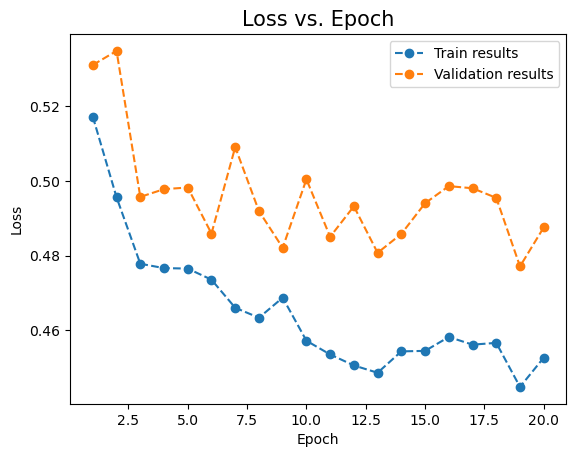

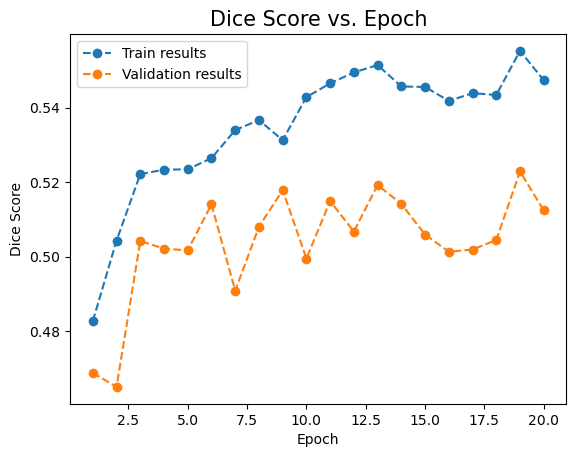

In [22]:
# run the training again
n_epochs = 20

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=batch_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # default LR -3
metric = utils.dice_score
train_losses, train_scores, val_losses, val_scores = run_training(model, train_loader, val_loader, loss, metric, optimizer, n_epochs)
plot('Loss vs. Epoch', 'Loss', train_losses, val_losses)
plot('Dice Score vs. Epoch', 'Dice Score', train_scores, val_scores)

In [23]:
# check out instance segmentation for a few test images
counter = 0
with torch.no_grad():
    for im, mask in test_loader:
        if counter >= 3:
            break
        pred = model(im.to(device))
        pred = torch.tensor(pred).cpu().numpy().squeeze()
        viewer = napari.Viewer()
        viewer.add_image(im.numpy(), name="Input")
        viewer.add_image(mask.numpy().squeeze()[0], name="Target Foreground")
        viewer.add_image(pred[0], name="Prediction Foreground")
        viewer.add_image(mask.numpy().squeeze()[1], name="Target Boundaries")
        viewer.add_image(pred[1], name="Prediction Boundaries")
        napari.run()
        counter += 1

/tmp/ipykernel_1255/1906957031.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(pred).cpu().numpy().squeeze()
/tmp/ipykernel_1255/1906957031.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(pred).cpu().numpy().squeeze()
/tmp/ipykernel_1255/1906957031.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(pred).cpu().numpy().squeeze()


In [24]:
# TODO: now run the model for all images in the test set. Run for the full image and save the result.
# You may need to use padding to make some of the images fit the model (if yes, then remove the padding afterwards).
# Please save the predictions using a similar naming scheme as in the bioimageio nucleus segmentation exercise

### 4. Run prediction

In [26]:
# We create a folder where we can save the cell membrane predictions.
output_folder = os.path.join(data_dir, "predictions", "cell-membranes")
os.makedirs(output_folder, exist_ok=True)

In [27]:
def pad_tensor(input_tensor, target_shape):
    batch_size, channels, height, width = input_tensor.shape
    pad_height = target_shape[2] - height
    pad_width = target_shape[3] - width

    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top

    padded_tensor = F.pad(input_tensor, (pad_left, pad_right, pad_top, pad_bottom))
    return padded_tensor, (pad_top, pad_bottom, pad_left, pad_right)  # Return padding information

def unpad_tensor(padded_tensor, padding_info):
    pad_top, pad_bottom, pad_left, pad_right = padding_info
    unpadded_tensor = padded_tensor[:, :, pad_top:padded_tensor.shape[2]-pad_bottom, pad_left:padded_tensor.shape[3]-pad_right]
    return unpadded_tensor

In [33]:
# We now define a function that applies the model for an image
# and then applies the connected component labeling.
def run_segmentation(model, image, target_shape=(1, 1, 1024, 1024), device=device):
    # Bring the input into the correct format and type.
    input_ = image[None,None] # add batch and channel dimensions
    input_ = torch.tensor(input_) # to tensor
    
    # Apply the model. Here, we use prediction with padding to deal with images
    # that have a shape that is not compatible with the model.
    # Predict with padding if the image is not in correct shape
    # to be processed by the network. 
    # Afterwards remove padding from prediction
    if input_.shape != target_shape:
        input_, padding_info = pad_tensor(input_, target_shape)
        pred = model(input_.to(device))
        pred = pred.clone().detach().cpu()
        pred = unpad_tensor(pred, padding_info)
        prediction = pred.numpy().squeeze()
    else:
        prediction = model(input_.to(device))
        prediction = prediction.cpu().numpy().squeeze()

    # Apply the pos-processing to get a segmentation mask.
    foreground, boundaries = prediction[0], prediction[1]
    
    return foreground, boundaries

In [34]:
# Get all the images for the nucleus channel in the test images.
input_files = glob(os.path.join(data_dir, "test", "gt_*", "*_serum_image.tif"))

In [37]:
# Run segmentation for all the test images.
# We add a progress bar to know how long it will take.

target_shape=(batch_size, 1, 1024, 1024)
with torch.no_grad():
    for path in tqdm.tqdm(input_files):
        image = imageio.imread(path)
        foreground, boundaries = run_segmentation(model, image, target_shape=target_shape)
    
        # We save the segmentation as a compressed tif, using a filename that matches the input name.
        filename = os.path.basename(path)
        output_path_foreground = os.path.join(output_folder, "foreground_"+filename)
        output_path_boundaries = os.path.join(output_folder, "boundaries_"+filename)
        imageio.imwrite(output_path_foreground, foreground)
        imageio.imwrite(output_path_boundaries, boundaries)

100%|██████████| 9/9 [00:01<00:00,  6.50it/s]


In [31]:
viewer = napari.Viewer()
viewer.add_image(imageio.imread(output_path))
napari.run()

## Possible Exercises

- Implement instance segmentation based on watershed from the instances. (This one we do for sure.)
- Validate the result with some metric

Advanced:
- Try with a larger U-Net
- Try different loss functions: CE, BCE, (with weighting)